In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
options(repr.matrix.max.rows = 10)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

<h1>DSCI 100 Project Final Report</h1>
    
<h3>Introduction:</h3>
Understanding player behaviour is essential for improving game design to retain long-term users and engagement. In this project, we analyzed data from Plaicraft, a Minecraft server operated by a research group at UBC to help them gain insight into their population of users. We explored the question: Can variables such as a player's age and experience level be used to predict the total hours played on the server? This will allow us to assess the extent of the association between these variables with player engagement. If strong correlations were found, it could provide information on future contribution given past participation and identify the key factors influencing player activity. Two datasets were provided to use for our analyses: the Players and the Sessions dataset, which gave information about the players and their gameplay activity. In the Players dataset, there are 197 observations about the demographic:

- experience (categorical skill level like "Pro", "Amateur", etc.)
- subscribe (logical variable indicating if they are subscribed)
- hashedEmail (unique anonymized ID)
- played_hours (numerical)
- name (categorical)
- gender (categorical)
- age (numerical)

In the Sessions dataset, there are 1536 observations on the individual gameplay sessions:

- hashedEmail (anonymized ID linked to the Players dataset)
- start_time (date and time player started)
- end_time (date and time player stopped)
- original_start_time (unix timestamp)
- original_end_time (unix timestamp)

However, the Sessions dataset was not used due to limitations that made it less suitable for our purposes. The original start time and end time were often identical for sessions under two hours, making it difficult to calculate the durations accurately. The data was also split across multiple records for each player, requiring preprocessing to combine the durations and then match them to the Players dataset. Therefore, using only the Players dataset, which already provided the total hours played, reduced the need for additional wrangling. To build our predictive model, we applied two different regression analyses: K-Nearest Neighbors (KNN) and linear regression and compared which model yields a lower RMSE. This helps us evaluate which technique better captures the relationship between age and experience level with hours played and how effective these variables are in modeling player behaviour.

<h3>Methods & Results:</h3>

The method used to perform our analysis was to conduct both K-nn and linear regression using age and experience level to see if they can independently predict the number of hours played. The players.csv and sessions.csv datasets were first loaded into R

In [2]:
players_url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"

players_data <- read_csv(players_url)

head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


Then for the players.csv dataset the columns that had data were selected, players_data, experience, subscribe, hashedEmail, played_hours, gender, and age. The empty columns were removed.

In [3]:
tidy_plaicraft <- players_data |>
    select(experience, subscribe, hashedEmail, played_hours, gender, age)
head(tidy_plaicraft)

experience,subscribe,hashedEmail,played_hours,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Female,17


We will use two different types of regression to determine if it is possible to predict the total hours played/total session frequency based on explanatory variables (age, gender, experience, etc). Thus, using regression modelling can help determine whether there is a relationship between the proposed predictors and our target responses. To select the best regression model we determined the RMSE & RMPSE and chose the model with the lowest error. We conducted these regressions with a 75% training and 25% test dataset split. Furthermore, to increase reliability conducted cross-validation to check the model for overfitting and performance using a 5 fold function. 

First we create a scatter plot of total hours played versus player age with experience shown by the colour and shape of the points (Using the training portion of the data in the split). This visualization provides a rough idea of what to expect in our predicted results. 

experience,subscribe,hashedEmail,played_hours,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<dbl>
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Male,17
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Female,17
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Male,17
Veteran,TRUE,bbe2d83de678f519c4b3daa7265e683b4fe2d814077f9094afd11d8f217039ec,0.0,Female,22
⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,a1e0438d568b9c05a93cadaf99969e4d44794d19dea31edd723cbc916f878c33,2.7,Non-binary,21
Amateur,FALSE,93efabc9f7de58f44c457bac715cf8f9f44cd88cc574fc02624cac194d2f0ea5,2.1,Male,24
Amateur,TRUE,42382bb2af563e6979c5b84d288cbb49bb2ef90b1bcf196c2902da4ce20eb7f3,0.8,Female,22


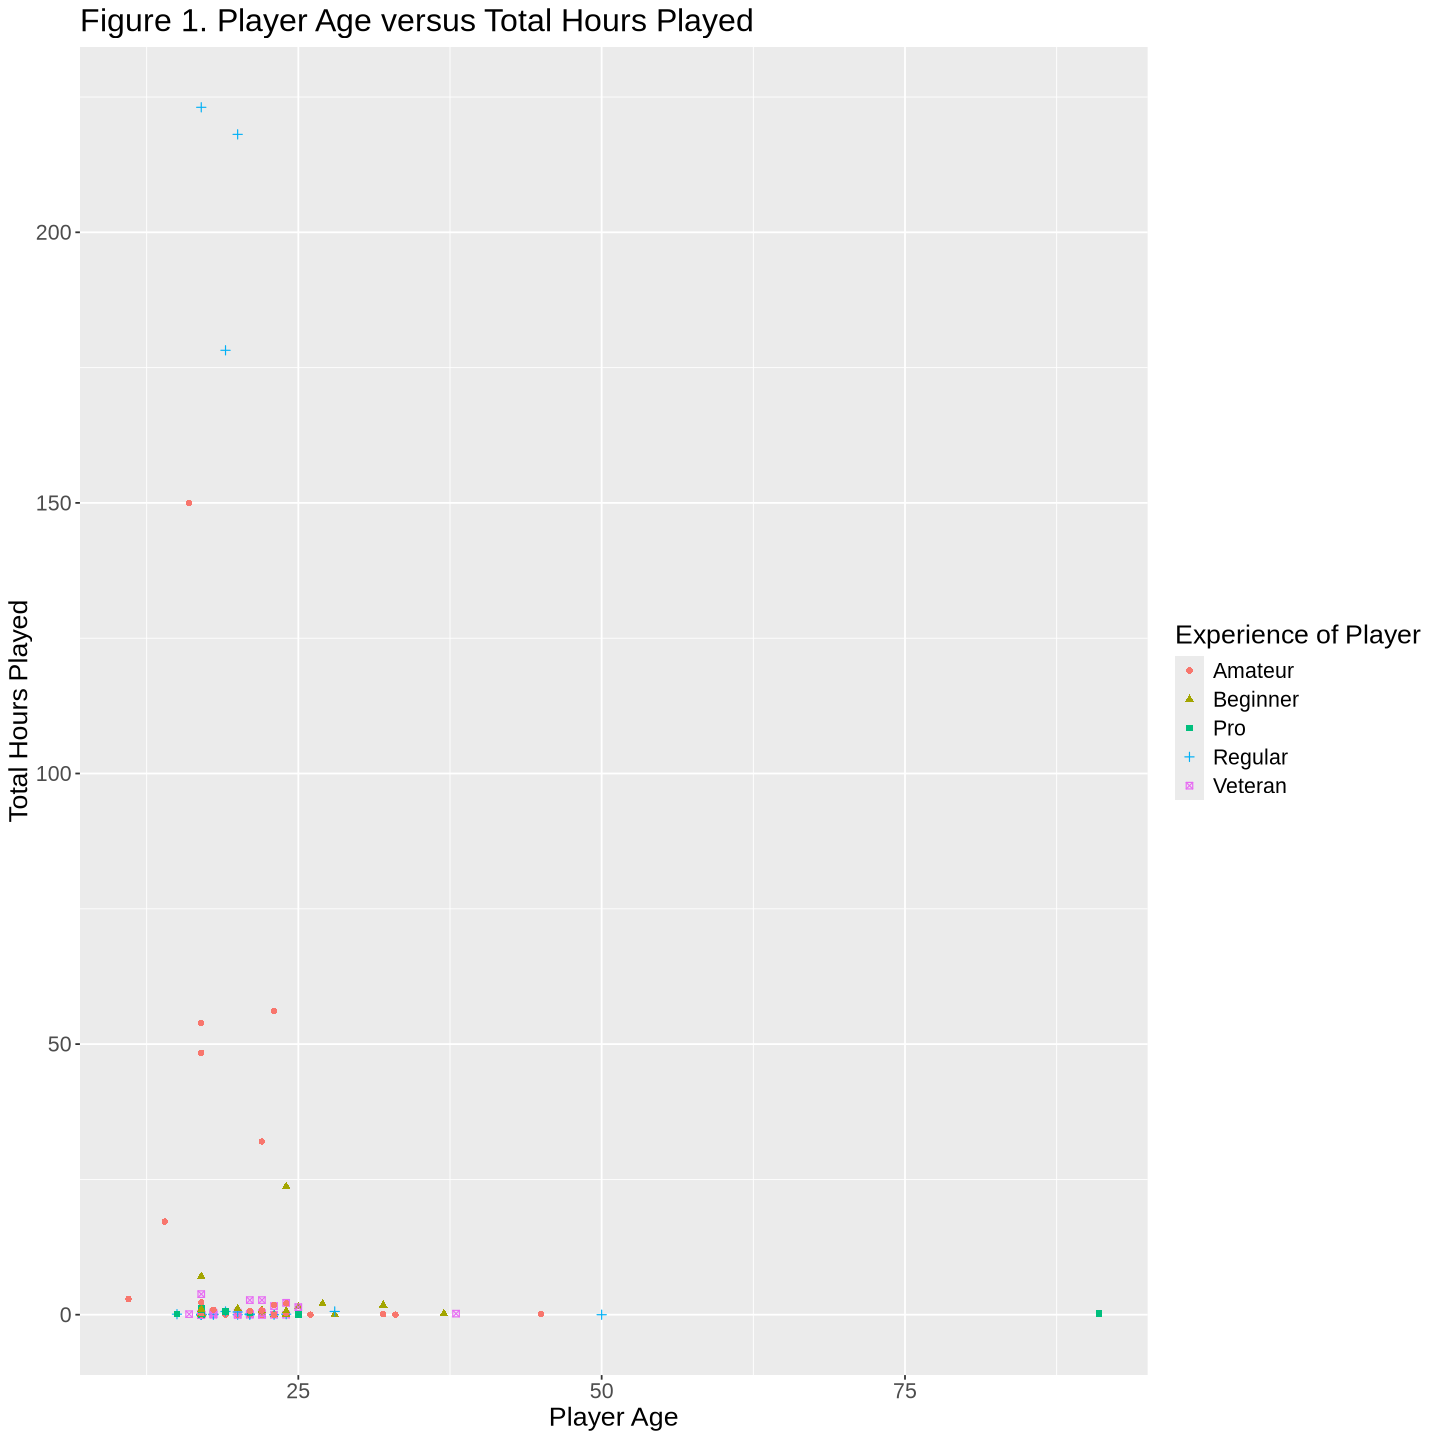

In [4]:
set.seed(411)

split <- initial_split(tidy_plaicraft, prop = 0.75, strata = played_hours)
training <- training(split)
training

options(repr.plot.height = 12, repr.plot.width = 12)
age_plot <- training |>
   ggplot(aes(x = age, y = played_hours, colour = experience, shape = experience)) +
   geom_point() +
   labs(x = "Player Age",
    	y = "Total Hours Played",
    	title = "Figure 1. Player Age versus Total Hours Played",
        colour = "Experience of Player",
        shape = "Experience of Player") +
   theme(text = element_text(size = 16))

age_plot

<h4>Age, KNN-Regression</h4>

For K-nn regression of age and played hours, the age data and played hours columns were selected from our players.csv dataset. The data was then split using a 0.75 ratio into a training and testing set. Next, the model function was created setting the engine and mode to knn regression, neighbors was also set to tune() in order to later select the optimal amount of neighbors to reduce error. Following this, the recipe function was created setting played_hours to be predicted by age, and using the step functions to scale all the predictors. To cross-validate we also used the vfold function with a 5 fold to check for the model’s performance and we added our recipe and model into our age workflow function to complete the preparation. 

In [5]:
age_data <- players_data|>
	select(age, played_hours)
      	 
head(age_data)

set.seed(411)

age_split <- initial_split(age_data, prop=0.75, strata = played_hours)
age_training <- training(age_split)
age_testing <- testing(age_split)

set.seed(411)

age_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
	set_engine("kknn")|>
	set_mode("regression")

age_recipe <- recipe(played_hours ~ age, data = age_training)|>
	step_scale(all_predictors()) |>
	step_center(all_predictors())

age_vfold <- vfold_cv(age_training, v=5, strata = played_hours)

age_workflow <- workflow()|>
	add_recipe(age_recipe)|>
	add_model(age_spec)

age_workflow

age,played_hours
<dbl>,<dbl>
9,30.3
17,3.8
17,0.0
21,0.7
21,0.1
17,0.0


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next to test all the potential neighbors we initiated the process using the gradvals function, then applied our age workflow to be tuned using our vfold function and gridval function. We then collected our RMPSE metric, filtered it for the lowest neighbor value, and pulled it out to set it as our kmin. The minimum RMPSE value occurs at K = 111 which is our kmin and that was selected for our knn model to fit onto our data. The preparation steps were then repeated again, now using the kmin neighbor value instead of tune(). As an additional step we created a small table of the .metric, .estimator, and .estimate of the lowest RMSE value that was pulled out. 

In [6]:
set.seed(411)

gridvals <- tibble(neighbors = seq(1, 113, by = 2))

age_results <- age_workflow|>
	tune_grid(resamples = age_vfold, grid = gridvals)|>
	collect_metrics()|>
	filter(.metric=="rmse")
 
head(age_results)

age_min <- age_results|>
	filter(mean==min(mean))

age_min

kmin <- age_min|>
	pull(neighbors)

age_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
  set_engine("kknn") |>
  set_mode("regression")

age_best_fit <- workflow() |>
  add_recipe(age_recipe) |>
  add_model(age_best_spec) |>
  fit(data = age_training)

age_rmse <- age_best_fit |>
  predict(age_testing) |>
  bind_cols(age_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == 'rmse')

age_rmse

→ A | warning: 113 samples were requested but there were 115 rows in the data. 110 will be used.

There were issues with some computations   A: x1

→ B | warning: 113 samples were requested but there were 117 rows in the data. 112 will be used.

There were issues with some computations   A: x1
→ C | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x3   C: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,29.47412,5,10.437025,Preprocessor1_Model01
3,rmse,standard,26.98451,5,9.512896,Preprocessor1_Model02
5,rmse,standard,29.49213,5,8.143220,Preprocessor1_Model03
7,rmse,standard,29.75922,5,8.116119,Preprocessor1_Model04
9,rmse,standard,28.92040,5,8.453160,Preprocessor1_Model05
11,rmse,standard,28.97369,5,8.659003,Preprocessor1_Model06


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,rmse,standard,26.98451,5,9.512896,Preprocessor1_Model02


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8.636651


With our best k neighbors value we then proceeded to create a scatter plot of the relationship between player age and played hours to determine the strength of the predictor of age to predict hours played.

.pred,age,played_hours
<dbl>,<dbl>,<dbl>
6.73333333,9,30.3
0.23333333,19,0.0
0.06666667,21,0.0
0.00000000,22,0.0
6.73333333,8,0.3
0.00000000,23,0.1


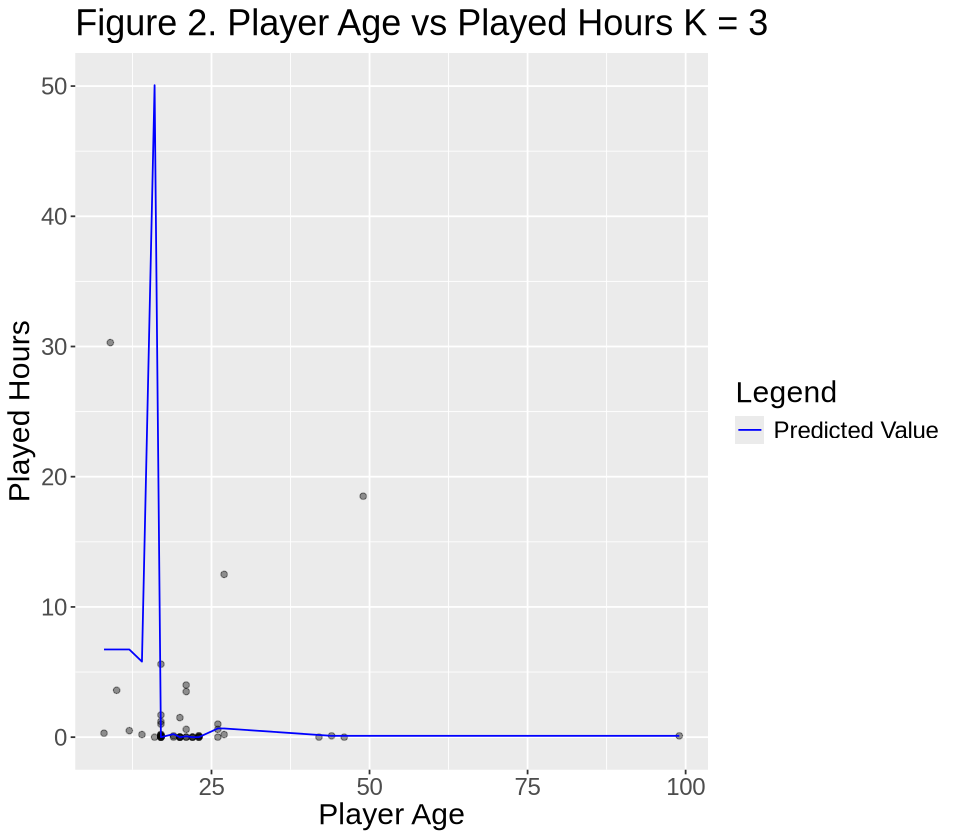

In [31]:
set.seed(411)
options(repr.plot.width=8, repr.plot.height=7)

age_prediction_grid <- tibble(age = seq(from = players_data |> select(age) |> min(),
                                    	to = players_data|> select(age) |> max(), by = 10))

age_preds <- age_best_fit|>
predict(age_testing)|>
bind_cols(age_testing)

head(age_preds)

age_plot <- age_preds|>
	ggplot(aes(x= age, y=played_hours))+
	geom_point(alpha = 0.4)+
	geom_line(data = age_preds, mapping =aes(x=age,y=.pred, color = "Predicted Value")) +
    scale_color_manual(name = "Legend", values = c("Predicted Value" = "blue")) +
	labs(x="Player Age", y= "Played Hours")+
	ggtitle(paste0("Figure 2. Player Age vs Played Hours K = ", kmin))+
	theme(text = element_text(size = 18))
age_plot

From the graph we determined that there was not a strong relationship between a player’s age and the number of hours they played. Secondly, based on our graph it seems the model does fit the model but it also seems to be very flat, indicating that the model may not be influenced enough by the training data. 


<h4>Age, Linear-Regression</h4>

In the following code, we use Linear Regression on the data with age of the player as the explanatory variable to predict a player’s total hours played in the server.

played_hours,age
<dbl>,<dbl>
30.3,9
3.8,17
0.0,17
0.7,21
0.1,21
0.0,17


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          age  
    12.5466      -0.2556  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,7.959298e+00
rsq,standard,4.001080e-06
mae,standard,7.270594e+00


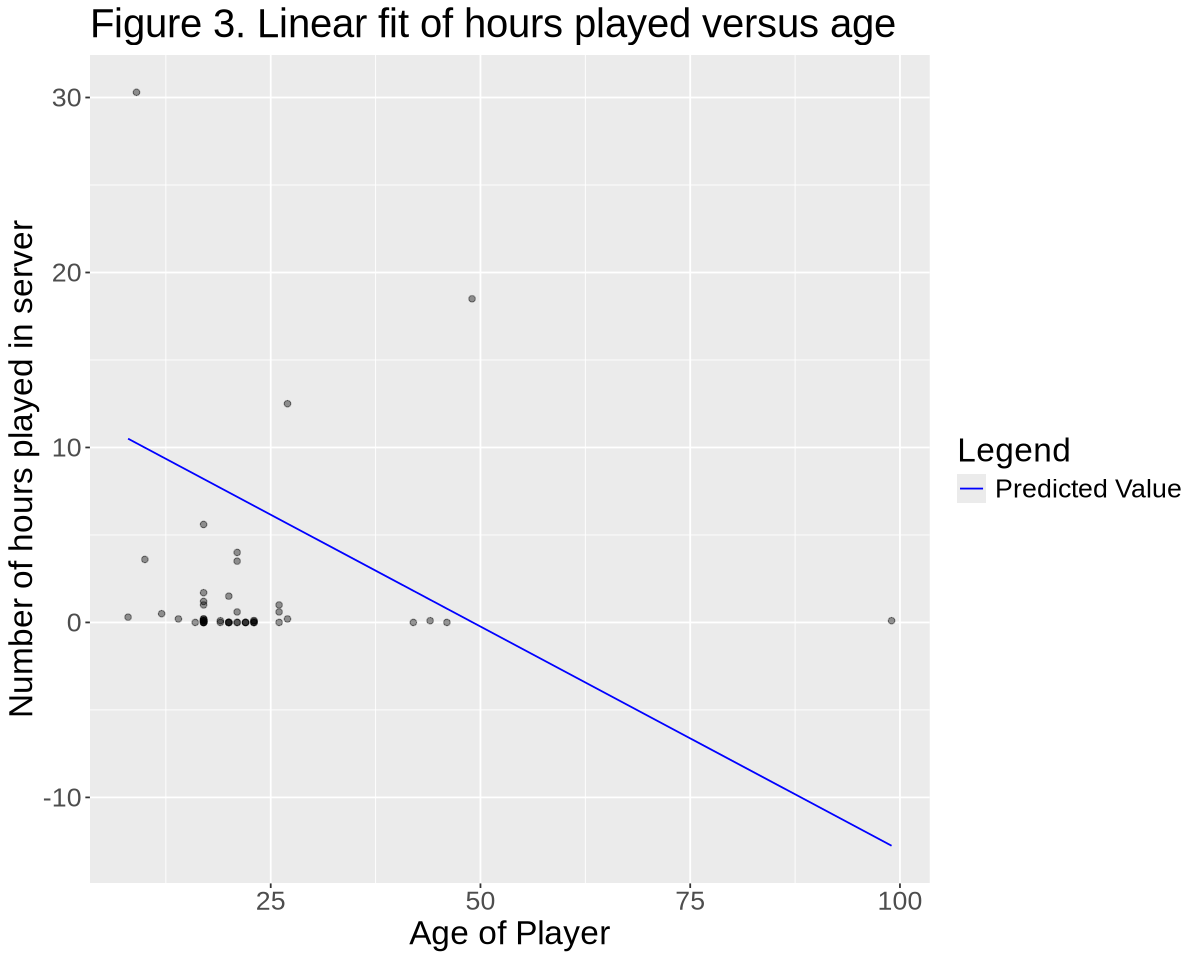

In [32]:
set.seed(411)
options(repr.plot.width = 10, repr.plot.height = 8)
players_age_data <- players_data |> 
    select(played_hours, age)

head(players_age_data)

players_split <- initial_split(players_age_data, prop = 0.75, strata = played_hours)
players_train <- training(players_split) 
players_test <- testing(players_split)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

players_recipe <- recipe(played_hours ~ age, data = players_train)

players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(lm_spec) |>
    fit(data = players_train)

players_fit

players_pred <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test)

players_test_results <- players_pred |>
    metrics(truth = played_hours, estimate = .pred)

lm_predictions <- players_pred |>
     ggplot(aes(x = age, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = players_pred,
             mapping = aes(x = age, y = .pred, color = "Predicted Value")) +
             scale_color_manual(name = "Legend", values = c("Predicted Value" = "blue")) +
         xlab("Age of Player") +
         ylab("Number of hours played in server") +
         ggtitle("Figure 3. Linear fit of hours played versus age") +
         theme(text = element_text(size = 20))

lm_predictions
players_test_results

<h4>Experience, KNN-Regression</h4>
Players dataset was downloaded and loaded into R and then selected for the specific columns experience and played_hours. 

In [9]:
players_experience_data <- select(players_data, experience, played_hours)

experience_data <- players_experience_data |>
   mutate(experience_rank = case_when(
       experience == "Veteran" ~ 5,
       experience == "Pro" ~ 4,
       experience == "Regular" ~ 3,
       experience == "Amateur" ~ 2,
       experience == "Beginner" ~ 1,
       TRUE ~ NA_real_)) |>
   select(experience_rank, everything())
head(experience_data)

experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
4,Pro,30.3
5,Veteran,3.8
5,Veteran,0.0
2,Amateur,0.7
3,Regular,0.1
2,Amateur,0.0


The experience column was converted to numerical scaling by ranking them from 1 to 5, assigning 5 for "Veteran" and lower values down to 1 for "Beginner". The dataset was then split into training (75%) and testing (25%) subsets with strata = played_hours to ensure the proportion was similar across both splits.

In [10]:
set.seed(411)
players_split <- initial_split(experience_data, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_testing <- testing(players_split)

set.seed(411)
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("regression")

players_recipe <- recipe(played_hours ~ experience_rank, data = players_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec)

players_gridvals <- tibble(neighbors = seq(1, , by = 2))

players_results <- players_workflow |>
   tune_grid(resamples = players_vfold, grid = players_gridvals) |>
   collect_metrics() |>
   filter(.metric == "rmse")

players_min <- players_results |>
    filter(mean == min(mean))
players_min

k_min <- players_min |>
   pull(neighbors)

→ A | warning: A correlation computation is required, but `estimate` is constant and has 0
               standard deviation, resulting in a divide by 0 error. `NA` will be returned.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,26.83821,5,9.54339,Preprocessor1_Model1


KNN regression model was created using recipe(), KNN model spec, v-fold cross validation on the training set for a grid of values for K, workflow combining recipe and KNN model, and filtering to find the best setting for number of neighbors with the minimum RMSE.

In [11]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min)|>
  set_engine("kknn") |>
  set_mode("regression")

players_best_fit <- workflow() |>
   add_recipe(players_recipe) |>
   add_model(players_best_spec) |>
   fit(data = players_training)

players_rmse <- players_best_fit |>
  predict(players_testing) |>
  bind_cols(players_testing) |>
  metrics(truth = played_hours, estimate = .pred) |>
  filter(.metric == "rmse")

players_preds <- players_best_fit |>
   predict(players_testing) |>
   bind_cols(players_testing)

players_preds

.pred,experience_rank,experience,played_hours
<dbl>,<dbl>,<chr>,<dbl>
0.0,4,Pro,30.3
0.1,3,Regular,0.0
0.1,2,Amateur,0.0
0.1,2,Amateur,0.0
0.1,3,Regular,0.3
⋮,⋮,⋮,⋮
0,5,Veteran,0.0
0,5,Veteran,0.1
0,4,Pro,0.2


After, the KNN model was retrained and fit using a new workflow.

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.461282


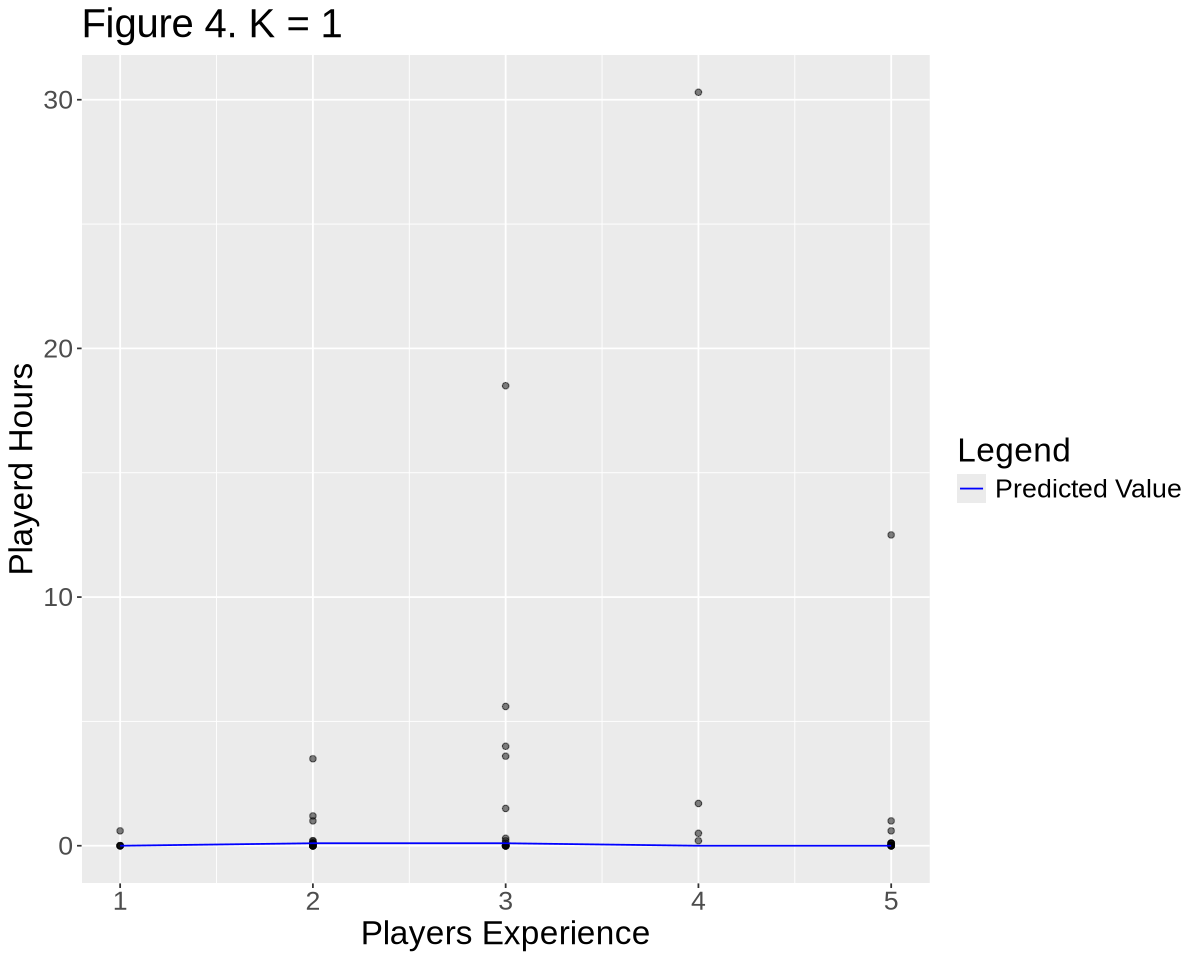

In [35]:
options(repr.plot.width = 10, repr.plot.height = 8)
players_plot <- players_preds |>
  ggplot(aes(x = experience_rank, y = played_hours)) +
  geom_point(alpha = 0.5) +
  geom_line(data = players_preds, mapping = aes(x = experience_rank, y = .pred, colour = "Predicted Value")) +
  scale_color_manual(name = "Legend", values = c("Predicted Value" = "blue")) +
  labs(x = "Players Experience",
       y = "Playerd Hours") +
   ggtitle(paste0("Figure 4. K = ", players_min)) +
  theme(text = element_text(size = 20))
 players_plot
players_rmse

Predictions were made for the testing set and calculated the RMSE using metrics() and used the prediction results for training to plot a scatter plot relationship between experience_rank and played_hours.


<h4>Experience, Linear-Regression</h4>

In [13]:
set.seed(411) 

player_split <- initial_split(experience_data, prop = 0.75)
player_training <- training(player_split)
player_testing <- testing(player_split)

head(player_training, n = 10)

experience_rank,experience,played_hours
<dbl>,<chr>,<dbl>
2,Amateur,0.0
5,Veteran,0.0
5,Veteran,0.0
3,Regular,0.0
2,Amateur,0.2
2,Amateur,0.1
2,Amateur,0.0
5,Veteran,12.5
2,Amateur,0.1


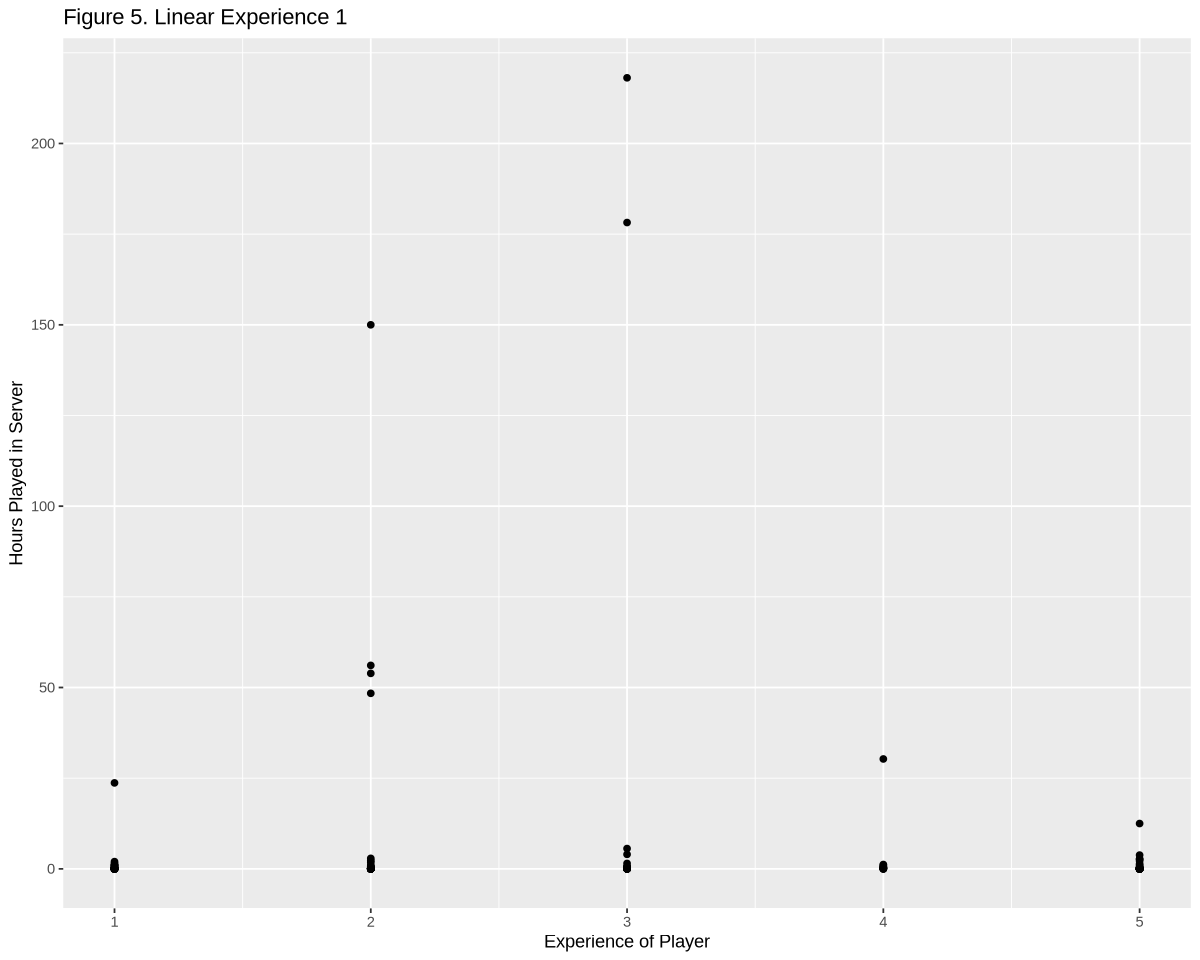

In [14]:
options(repr.plot.width = 10, repr.plot.height = 8)
plotting <- ggplot(player_training, aes(x = experience_rank, y = played_hours)) +
    geom_point() +
    labs(x = "Experience of Player", y = "Hours Played in Server", title = "Figure 5. Linear Experience 1")

plotting 

Did an initial plot of the training data to get an idea on how the data looks.

In [15]:
set.seed(411)

lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

lm_recipe <- recipe(played_hours ~ experience_rank, data = player_training)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(data = player_training)

lm_fit

set.seed(411)

training_preds <- lm_fit |>
    predict(player_training) |>
    bind_cols(player_training)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
    (Intercept)  experience_rank  
         7.7011          -0.7134  


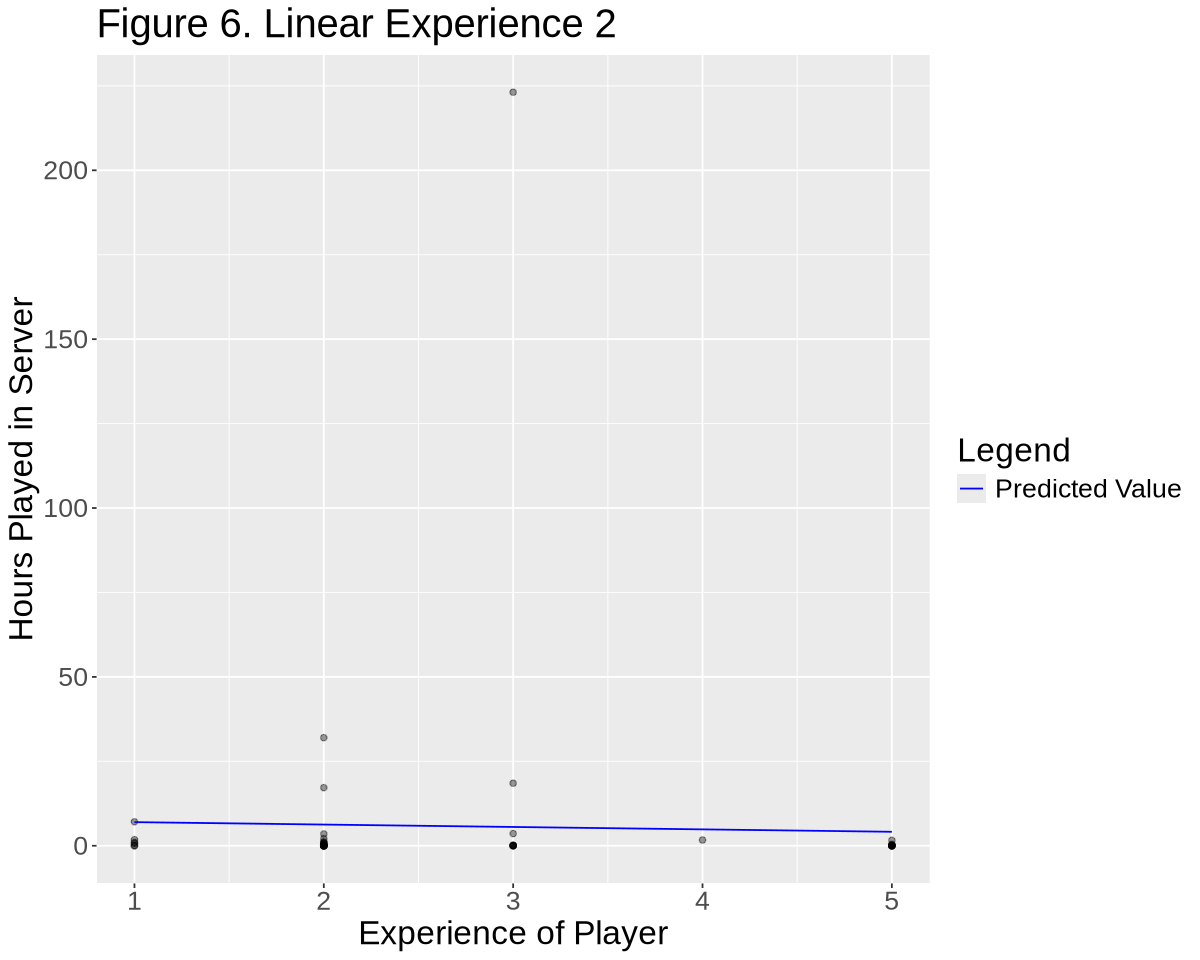

In [36]:
set.seed(411)
options(repr.plot.width = 10, repr.plot.height = 8)
testing_pred <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing)

experience_results <- testing_pred |>
    metrics(truth = played_hours, estimate = .pred)

testing_predictions <- testing_pred |>
     ggplot(aes(x = experience_rank, y = played_hours)) +
        geom_point(alpha = 0.4) +
         geom_line(data = testing_pred,
             mapping = aes(x = experience_rank, y = .pred, colour = "Predicted Value")) +
             scale_color_manual(name = "Legend", values = c("Predicted Value" = "blue")) +
         xlab("Experience of Player") +
         ylab("Hours Played in Server") +
    labs(title = "Figure 6. Linear Experience 2") +
         theme(text = element_text(size = 20))

testing_predictions

Then predicted results with testing data and plotted it as well.

In [17]:
testing_results <- lm_fit |>
    predict(player_testing) |>
    bind_cols(player_testing) |>
    metrics(truth = played_hours, estimate = .pred) 

testing_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.178883e+01
rsq,standard,1.437197e-06
mae,standard,1.010228e+01


<h3>Discussion:</h3>

**Experience as a predictor:**

Between all of our tested variables there seems to be a very slight negative correlation. Whereas a player’s experience level and age increase, their hours played decreases. However, our data suggests all findings are inconclusive, the predictors are pretty weak. Experience had a slight negative correlation which can be visibly observed on the linear regression data graph, but there also seems to be many outliers. The experience data points were unequally distributed, with a larger concentration near and at zero for played hours which resulted in the predicted values which formed out blue lines to remain relatively flat. This creates the issue of interpreting the data in the Knn regression graph, since the original data points are relatively flat, it is difficult to determine how well our predicted line fits the actual data. As under normal circumstances, overfitting/underfitting can be determined by how steep/flat the predicted line is. From the given dataset, player experience is not a strong predictor of hours played. Other variables besides just experience alone are needed to create a stronger predictor. The results are expected since we observed that there were many 0 values to begin with. Therefore, to determine whether the correlation truly exists, the dataset must be expanded and then retested in the future. 

**Age as a predictor:**

Similarly, age had an even weaker slight negative correlation which is barely noticeable on the linear regression graph. The age data points were also unequally distributed, with many near zero or zero played hours points. As a result, our blue line representing the predicted values is almost flat. This creates the same issues of interpretation as our experience data. It is difficult to determine the fit of our line to the data. To determine whether there exists a correlation, the dataset should be expanded and retested. 

**Lowest RMSE:**

The RMSE for Knn regression for age was 8.64 and for scaled experience it was 5.46. The RMSE for linear regression for age 7.96 and for scaled experience it was 31.78. Based on the lowest RMSE values, the linear regression model fits relatively better for age compared to Knn. For scaled experience the Knn regression model fits relatively better compared to the linear regression model. Although it is difficult to conclude anything concretely, the RMSE results imply that for age the correlation may expand beyond the domain of the dataset resulting in the linear regression model being a better fit. Whereas, for scaled experience the predicted values were more accurate within the domain of the data, resulting in the better fit of the Knn regression model.

**Other recommendations:**

After our group’s analyses of the Plaicraft data, we determined a list of key recommendations. The primary issue is that the players.csv dataset is too small, there isn’t enough data points to accurately determine whether a correlation exists between our chosen variables and played hours. Therefore, these findings indicate that experience level is not a useful metric for predicting player engagement. Presumably, other factors besides experience alone would be more significant in determining hours played. We considered using gender as well as a predictor for played hours but our initial data wrangling and cleaning showed a heavy skew of male players with female, non-binary, two-spirited, and other genders not having equal or similar representation. Another recommendation is to gather more data from players that identify as female, non-binary, two-spirited, or other before a more in depth analysis. 
Game developers would need to consider additional variables to predict user behaviour effectively as focusing just on age or experience will lead to inconclusive results/false assumptions about player activity. It leads to future questions about whether other variables would be able to predict played hours better or if larger datasets with longer hours played could improve the model's performance using age and experience level. As well as, how would removing outliers affect the model's accuracy.



<h3>References:</h3>
1. Hoelsher, A. (2018, May 23). Add legend to geom_line() graph in r. StackOverflow. https://stackoverflow.com/questions/40833809/add-legend-to-geom-line-graph-in-r
